### This notebook aims to recreate the Autoencoder Asset Pricing Model proposed by Gu et al. (2020a). 
https://slides.com/connorchapin/aapm/fullscreen

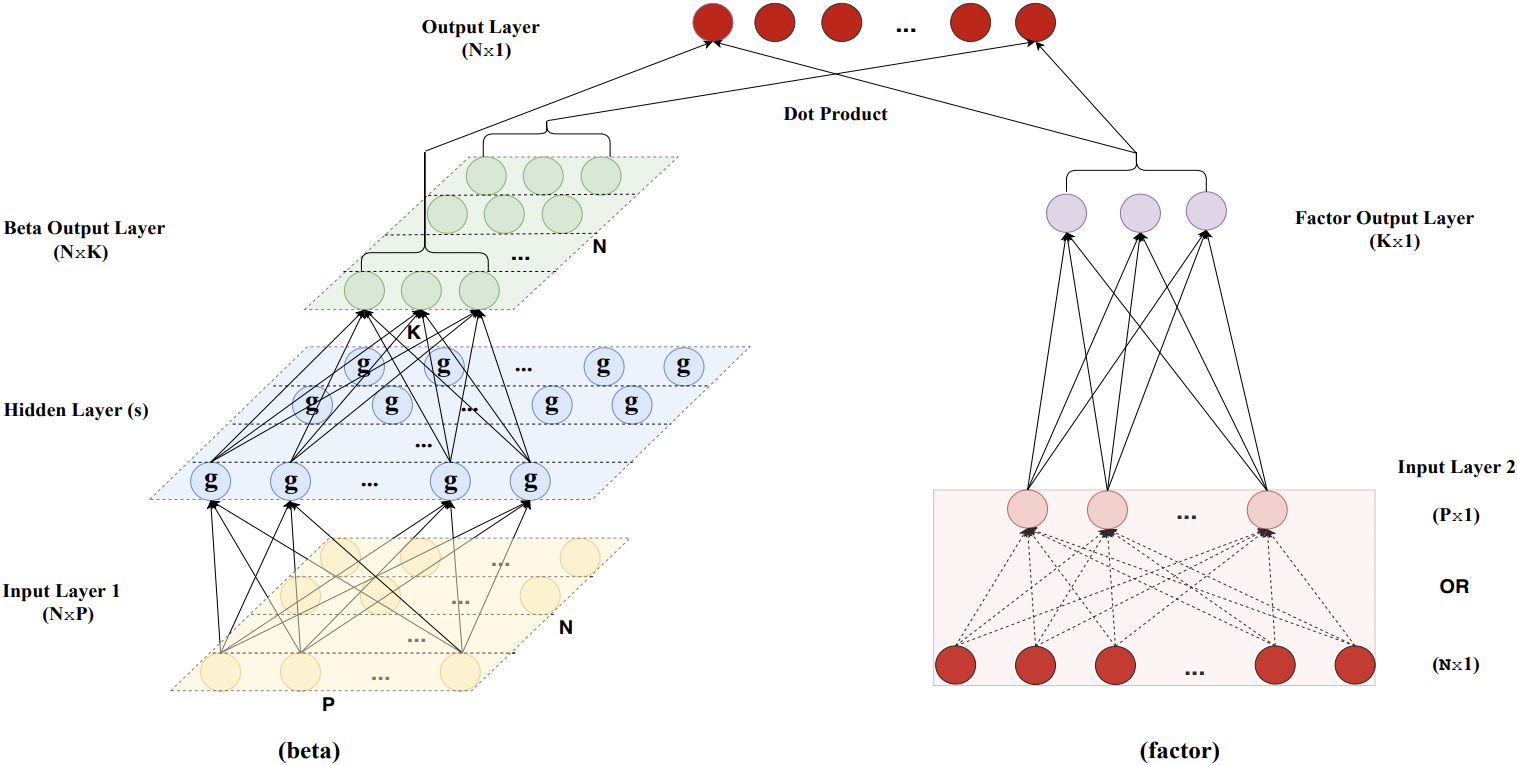

Note: This figure presents the diagram of an autoencoder augmented to incorporate covariates in the factor
loading specification. 

The left-hand side describes how factor loadings <i>β<sub><i>t</i> − 1</sub></i> at time <i>t</i> − 1 (in green) depend on firm characteristics <i>Z<sub>t − 1</sub></i> (in yellow) of the input layer 1 through an activation function <i>g</i> on neurons of the hidden layer. Each row of yellow neurons represents the <i>P</i> × 1 vector of characteristics of one ticker. 

The right-hand side describes the corresponding factors at time <i>t</i>. <i>f<sub>t</sub></i> nodes (in purple) are weighted combinations of neurons of the input layer 2, which can either be <i>P</i> characteristic-managed portfolios <i>x<sub>t</sub></i> (in pink) or <i>N</i> individual asset returns <i>r<sub>t</sub></i> (in red). In the latter case, the input layer 2 is exactly what the output layer aims to approximate, which is the same as a standard autoencoder.

### Covariate
Continuous variable that is expected to change (“vary”) with (“co”) the outcome variable of a study.

In [1]:
# Custom function to transform the date in 5 factors dataframe
def to_date(row):
    year = str(row)[:4]
    month = str(row)[4:6]
    day = str(row)[6:]

    return pd.to_datetime('-'.join([year, month, day]))

In [67]:
# Import dependicies
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [236]:
df = pd.read_csv('clean_data.csv')
df

,date,ticker,returns,month spead,high off close,low off close,high of open,low off open,volume,Accounts Payable,...,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding
0,12/31/2015,AAL,-0.021036,0.739998,0.005168,0.012431,0.000705,-0.016973,6788900,5.102000e+09,...,4.841500e+10,9.985000e+09,13605000000,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.000000e+00,11.39,6.681299e+08
1,12/31/2015,ABBV,0.003728,0.729999,0.011513,0.000676,0.007175,-0.005068,6019300,8.463000e+09,...,5.305000e+10,1.631400e+10,10894000000,3.945000e+09,4.910500e+10,5.305000e+10,2.285900e+10,-8.839000e+09,3.15,1.633016e+09
2,12/31/2015,ABT,-0.012099,0.599998,0.012967,0.000223,0.008571,-0.004677,4156700,5.683000e+09,...,4.124700e+10,1.415500e+10,9186000000,2.121100e+10,2.003600e+10,4.124700e+10,2.040500e+10,-1.062200e+10,2.94,1.504422e+09
3,12/31/2015,ADM,-0.000545,0.450001,0.005962,0.006310,0.007046,-0.005213,2516800,1.340700e+10,...,4.015700e+10,2.182900e+10,13505000000,1.789900e+10,2.224200e+10,4.014100e+10,6.770200e+10,0.000000e+00,2.99,6.183946e+08
4,12/31/2015,ADS,-0.043540,4.890015,0.011862,0.005709,0.015971,-0.001527,262100,1.010619e+09,...,2.242183e+10,1.625042e+10,6405559000,2.010030e+09,2.041180e+10,2.242183e+10,6.439746e+09,-3.927345e+09,8.91,6.695185e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,12/31/2015,XYL,-0.030287,0.389999,0.009229,0.001372,0.004615,-0.006036,635100,7.450000e+08,...,4.657000e+09,2.005000e+09,823000000,2.084000e+09,2.573000e+09,4.657000e+09,3.653000e+09,-3.990000e+08,1.88,1.808511e+08
313,12/31/2015,YHOO,-0.013349,0.509999,0.012763,0.002411,0.013951,-0.001206,7396000,1.143349e+09,...,4.520397e+10,7.507319e+09,1277380000,2.904354e+10,1.616043e+10,4.520397e+10,4.968301e+09,-9.115330e+08,-4.64,9.394573e+08
314,12/31/2015,ZBH,-0.001266,1.469993,0.005236,0.009148,0.011151,-0.003148,659600,4.320000e+08,...,2.721950e+10,5.862900e+09,1617900000,9.887900e+09,1.733160e+10,2.721950e+10,5.997800e+09,-6.329100e+09,0.78,1.884615e+08
315,12/31/2015,ZION,-0.102269,0.500000,0.012301,0.005895,0.013748,-0.004422,1737600,0.000000e+00,...,5.966952e+10,0.000000e+00,0,7.507519e+09,5.216201e+10,5.966952e+10,2.210591e+09,0.000000e+00,1.20,2.578925e+08


In [237]:
# Define firm characteristics, which will be used as input for the beta network
firm_characteristics = df.iloc[:, 3:]

# Define returns, which will be used as input for the factor network
returns = df[['returns']]

# Standard scaling the inputs defined above
scaler_characteristics = StandardScaler()
scaler_returns = StandardScaler()

firm_characteristics = scaler_characteristics.fit_transform(firm_characteristics)
returns = scaler_returns.fit_transform(returns)

In [238]:
# The AutoEncoder Asset Pricing Model
class AutoEncoder_Asset_Pricing_Model(torch.nn.Module):
    def __init__(self, N, P, S, K):
        self.N = N
        self.P = P
        self.S = S
        self.K = K
        super().__init__()
        
        # Beta Network: N x p -> S -> N x K
        self.beta_network = torch.nn.Sequential(        
            torch.nn.Linear(N * P, S),
            torch.nn.ReLU(),
            torch.nn.Linear(S, N * K),
            torch.nn.ReLU()
        )
        
        # Factor Network: N -> p -> K
        self.factor_network = torch.nn.Sequential(
            torch.nn.Linear(N, P * 1),
            torch.nn.ReLU(),
            torch.nn.Linear(P, K * 1)
        )

    def forward(self, characteristics, returns):
        # The firm characteristics are used as input for beta network
        characteristics = torch.flatten(characteristics)
        loaded_beta = self.beta_network(characteristics)
        
        # The returns are used as input for factor network
        returns = torch.flatten(returns)
        loaded_factor = self.factor_network(returns)
        
        # The modeled returns will be obtained by multiplying 
        # the output of beta network and factor network
        loaded_beta = loaded_beta.view(self.N, self.K)
        loaded_factor = loaded_factor.view(self.K, 1)
        final = torch.mm(loaded_beta, loaded_factor)
        
        return final


In [288]:
# Define the dimensions of the autoencoder asset pricing model
N, P, S, K = len(df), 81, 32, 81

# Build the model
model = AutoEncoder_Asset_Pricing_Model(N, P, S, K)
print(model)

AutoEncoder_Asset_Pricing_Model(
  (beta_network): Sequential(
    (0): Linear(in_features=25677, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=25677, bias=True)
    (3): ReLU()
  )
  (factor_network): Sequential(
    (0): Linear(in_features=317, out_features=81, bias=True)
    (1): ReLU()
    (2): Linear(in_features=81, out_features=81, bias=True)
  )
)


In [289]:
# DataLoader is used to load the dataset for training
betas_loader = torch.utils.data.DataLoader(dataset=firm_characteristics, batch_size=N, shuffle=False)
factor_loader = torch.utils.data.DataLoader(dataset=returns, batch_size=N, shuffle=False)

In [290]:
# specify loss function
criterion = torch.nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    for b, f in zip(betas_loader, factor_loader):
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(b.float(), f.float())
        
        # calculate the loss
        loss = criterion(outputs, f.float())
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()
            
    # print avg training statistics 
    train_loss = train_loss / len(betas_loader)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

Epoch: 10 	Training Loss: 0.998517
Epoch: 20 	Training Loss: 0.959248
Epoch: 30 	Training Loss: 0.894532
Epoch: 40 	Training Loss: 0.788687
Epoch: 50 	Training Loss: 0.594616
Epoch: 60 	Training Loss: 0.344352
Epoch: 70 	Training Loss: 0.182955
Epoch: 80 	Training Loss: 0.083328
Epoch: 90 	Training Loss: 0.035887
Epoch: 100 	Training Loss: 0.014154


In [296]:
# Inspect the modeled returns
for x, y in zip(betas_loader, factor_loader):
    result = model(x.float(), y.float())
    result = scaler_returns.inverse_transform(result.detach())

result = result.flatten()
result = pd.Series(result)
result[:5]

0   -0.021674
1    0.005818
2   -0.012869
3    0.001145
4   -0.043066
dtype: float32

In [291]:
# The true returns 
df.returns.head(5)

0   -0.021036
1    0.003728
2   -0.012099
3   -0.000545
4   -0.043540
Name: returns, dtype: float64